# Polynomial Regression Analysis – Supervised Learning Project

This notebook is part of **Deliverable 1** of the Supervised Learning Project.

The objective of this work is to analyze how certain physical measurement features, such as *normalized time*, *average depth stability (standard deviation)*, and *angular standard deviation*, are related to each other.  

We use supervised learning to model and predict relationships using Linear Regression and Polynomial Regression.  

All analyses, results, and visualizations are implemented in Python using the `scikit-learn`, `pandas`, `matplotlib`, and `seaborn` libraries.

### Problem Description

The goal is to predict the cumulative standard deviation of the angular measurement (Φₓ)  
based on different independent variables from measurement data:

- `std_average_depth` — cumulative standard deviation of the average depth variation  
- `normalized_time` — normalized time variable  
- `cumulative_std_angle_x` — cumulative standard deviation of angle Φₓ (target variable)

These relationships are relevant for understanding stability and precision over time in a physical measurement process.

We approach this as a regression problem (supervised learning), where:
- The target variable (y) is continuous,
- The input features (X) are numerical predictors.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

### Data Overview and Cleaning

Before modeling, we perform a short exploratory data analysis (EDA) to inspect the dataset,  
handle missing values, and prepare the data for regression.

**Steps performed:**
1. Cleaning and removing NaN values
2. Checking feature correlations
3. Normalizing the time variable
4. Visualizing relationships via scatter plots and pair plots

This step ensures the data is consistent and suitable for supervised learning.


In [2]:
# Load the data
data = pd.read_csv('Messreihe_demo1.csv')

# Check the first few rows
print(data.head())

# Normalize the 'timestamp' column
if 'timestamp' in data.columns:
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')  # Conversion from milliseconds
        start_time = data['timestamp'].iloc[0]  # First timestamp
        data['normalized_time'] = (data['timestamp'] - start_time).dt.total_seconds()  # Normalization in seconds

        # Adjustment of the normalized time
        for i in range(len(data) - 1):
            if data['timestamp'].iloc[i + 1] < data['timestamp'].iloc[i]:
                # Adjust all subsequent values
                for j in range(i + 1, len(data)):
                    data.loc[j, 'normalized_time'] += 1000
        data['normalized_time'] = data['normalized_time'].values
        x_data = np.arange(len(data['normalized_time']))

#print(x, x_data)

# Convert 'depth_values_20mm' from string to list
data['depth_values_20mm'] = data['depth_values_20mm'].apply(lambda x: eval(x))

# Calculate the average depth for each row
data['average_depth'] = data['depth_values_20mm'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)

# Calculate cumulative standard deviation
data['cumulative_std_angle_x'] = data['angle_x_20mm'].expanding().std()
data['cumulative_std_angle_y'] = data['angle_y_20mm'].expanding().std()
data['std_average_depth'] = data['average_depth'].expanding().std()

# Check for missing values (before cleaning)
print("\nNumber of missing values (before cleaning):")
print(data.isnull().sum())

# Cleaning the DataFrame and removing NaN values
data_cleaned = data.dropna(subset=['average_depth',
                                     'std_average_depth',
                                     'normalized_time',
                                     'cumulative_std_angle_x',
                                     'cumulative_std_angle_y',
                                     'angle_y_20mm',
                                     'angle_x_20mm'])

# Checking for NaN values in data_cleaned (after cleaning)
print("\nNumber of NaN values in data_cleaned (after cleaning):")
print(data_cleaned.isnull().sum())

   timestamp  angle_x_20mm  angle_y_20mm  \
0      36131     86.976160    124.594380   
1      95976     86.976160    124.594380   
2     131883     87.096747    124.537648   
3     170289     86.933806    124.867205   
4     201206     87.085374    124.503887   

                                   depth_values_20mm  
0  [79.2999979967135, 79.2999979967135, 79.299997...  
1  [79.2999979967135, 79.2999979967135, 79.299997...  
2  [79.39999799418729, 79.2999979967135, 79.29999...  
3  [79.39999799418729, 79.2999979967135, 79.29999...  
4  [79.39999799418729, 79.2999979967135, 79.29999...  

Number of missing values (before cleaning):
timestamp                 0
angle_x_20mm              0
angle_y_20mm              0
depth_values_20mm         0
normalized_time           0
average_depth             0
cumulative_std_angle_x    1
cumulative_std_angle_y    1
std_average_depth         1
dtype: int64

Number of NaN values in data_cleaned (after cleaning):
timestamp                 0
angle_x_20m

**Visualizing relationships via scatter plots and pair plots:**

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


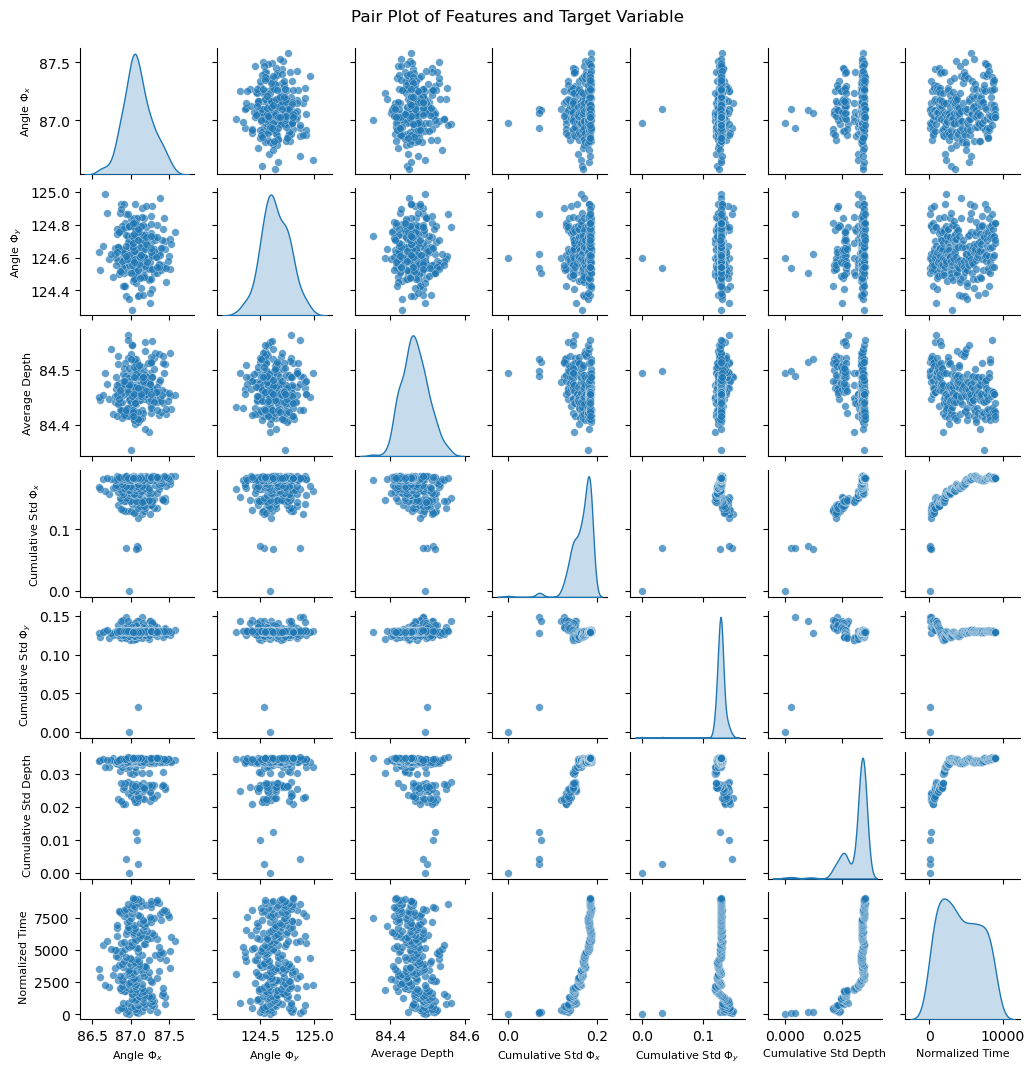

In [3]:
# Pair plot to visualize relationships between features and the target variable
# Set the size of the pair plot
plot_size = 1.5

mpl.rcParams['figure.autolayout'] = True

# Create a pair plot with custom marker size
pair_plot = sns.pairplot(data_cleaned[['angle_x_20mm', 
                                 'angle_y_20mm', 
                                 'average_depth', 
                                 'cumulative_std_angle_x', 
                                 'cumulative_std_angle_y',
                                 'std_average_depth',
                                 'normalized_time']],
                         diag_kind='kde',
                         height=plot_size,
                         plot_kws={
                             's': 30,
                             'alpha': 0.7,
                             #'edgecolor': 'black',
                             'linewidth': 0.25
                         })

# Set the title
plt.suptitle('Pair Plot of Features and Target Variable', y=1.02)

# Change the labels to be more readable
new_labels = {
    'angle_x_20mm': 'Angle $\Phi_x$',
    'angle_y_20mm': 'Angle $\Phi_y$',
    'average_depth': 'Average Depth',
    'cumulative_std_angle_x': 'Cumulative Std $\Phi_x$',
    'cumulative_std_angle_y': 'Cumulative Std $\Phi_y$',
    'std_average_depth': 'Cumulative Std Depth',
    'normalized_time': 'Normalized Time'
}

# Loop through the axes and set new labels
for ax in pair_plot.axes.flatten():
    current_x_label = ax.get_xlabel()
    current_y_label = ax.get_ylabel()
    
    # Check if the current labels are in the new_labels dictionary
    if current_x_label in new_labels:
        ax.set_xlabel(new_labels[current_x_label], fontsize=8)  # Set x-axis label
    if current_y_label in new_labels:
        ax.set_ylabel(new_labels[current_y_label], fontsize=8)  # Set y-axis label

plt.show()

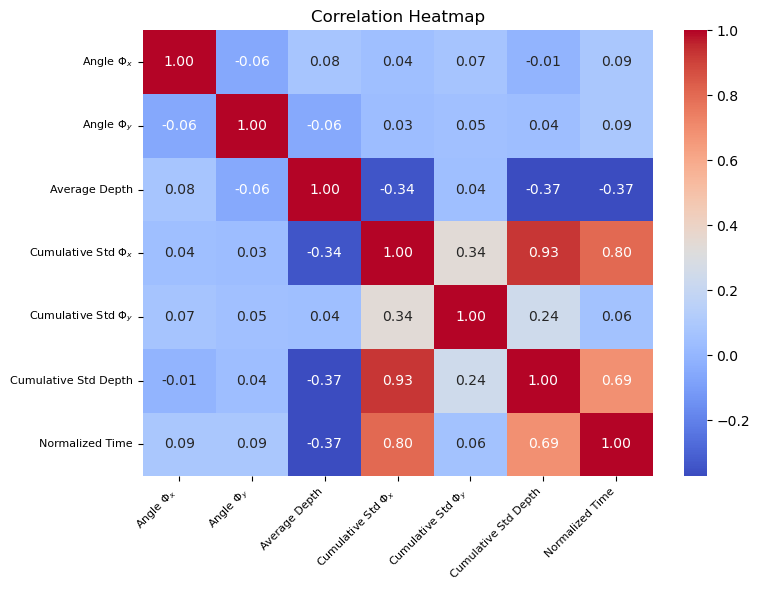

In [4]:
# Calculate correlations
correlation_matrix = data[['angle_x_20mm', 'angle_y_20mm', 'average_depth', 'cumulative_std_angle_x', 'cumulative_std_angle_y', 'std_average_depth', 'normalized_time']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Set new labels
heatmap.set_xticklabels([new_labels[label] for label in correlation_matrix.columns], rotation=45, ha='right', fontsize=8)
heatmap.set_yticklabels([new_labels[label] for label in correlation_matrix.index], rotation=0, fontsize=8)

plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (EDA)

We examine the distributions and pairwise relationships between variables.

Key findings:
- There is a visible positive correlation between `normalized_time` and `cumulative_std_angle_x` (0.80), between `normalized_time` and `std_average_depth` (0.69) and between `cumulative_std_angle_x` and `std_average_depth` (0.93).
- The relationship between `std_average_depth` and `cumulative_std_angle_x` could be linear, the other relationships are non-linear.
- A polynomial regression model might capture these effects better than a simple linear model.

### Model Building and Training

We apply and compare two main regression approaches:

1. Linear Regression: baseline model (Polynomial Regression of degree 1)
2. Polynomial Regression (degrees 2–10): to capture nonlinear relationships  

Each model is evaluated using:
- Train/Test Split (80/20)
- Cross-Validation (10-fold)
- Metrics: R² (coefficient of determination) and MSE (mean squared error)

This allows us to determine which model complexity provides the best generalization.

# Univariate analysis

## Analysis of the relationship of `std_average_depth` and `cumulative_std_angle_x`

We will now perform the analysis to find the best degree for this model by splitting the data into a training and test sample and looping over polynomial degrees:

Polynomial Regression Results (Train/Test Split):
 Degree  R²_Train  R²_Test  MSE_Train  MSE_Test
      1  0.869159 0.827756   0.000078  0.000067
      2  0.869706 0.828797   0.000077  0.000067
      3  0.875526 0.837748   0.000074  0.000063
      4  0.876213 0.840452   0.000073  0.000062
      5  0.896018 0.834384   0.000062  0.000064
      6  0.903059 0.844577   0.000058  0.000060
      7  0.905193 0.852099   0.000056  0.000058
      8  0.908152 0.858369   0.000055  0.000055
      9  0.908156 0.858375   0.000055  0.000055
     10  0.908156 0.858376   0.000055  0.000055

Best degree by Test R²: 10
Best degree by Test MSE: 10


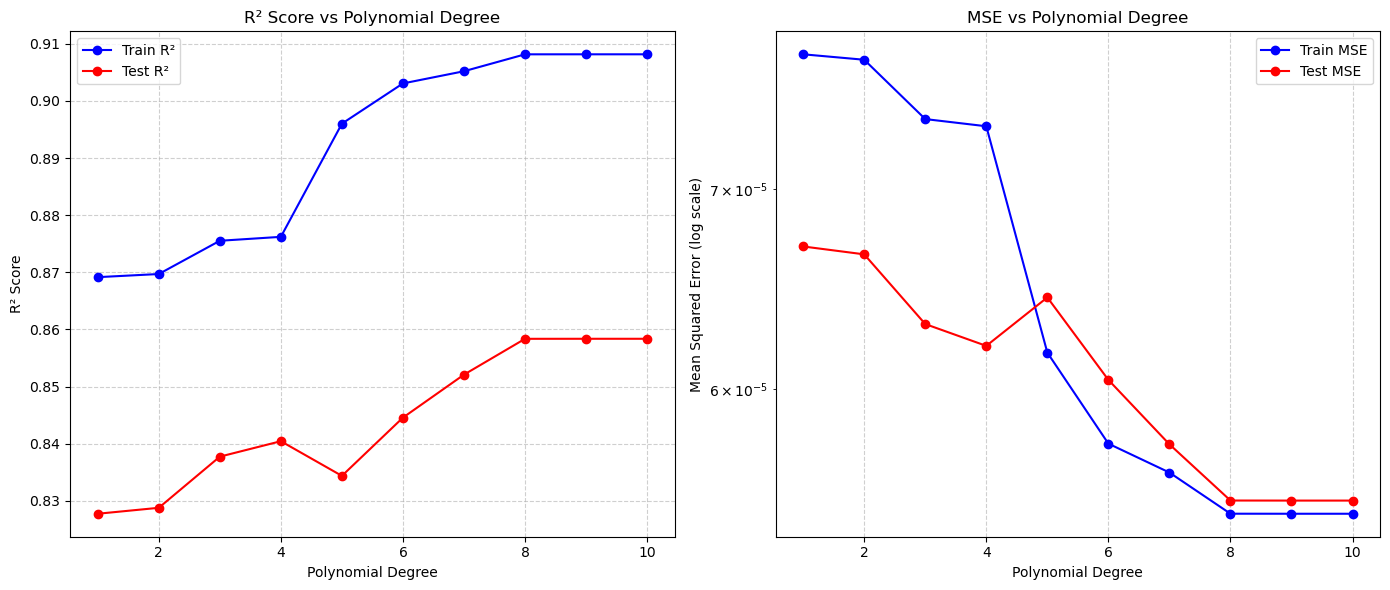

In [5]:
# --- Prepare data ---
X = data_cleaned[['std_average_depth']].values
y = data_cleaned['cumulative_std_angle_x'].values

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Storage for metrics ---
results = []

# --- Loop over polynomial degrees 1–10 ---
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    results.append((degree, r2_train, r2_test, mse_train, mse_test))

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results, columns=['Degree', 'R²_Train', 'R²_Test', 'MSE_Train', 'MSE_Test'])

# --- Identify best degree ---
best_degree_r2 = results_df.loc[results_df['R²_Test'].idxmax(), 'Degree']
best_degree_mse = results_df.loc[results_df['MSE_Test'].idxmin(), 'Degree']

print("Polynomial Regression Results (Train/Test Split):")
print(results_df.to_string(index=False))
print("\nBest degree by Test R²:", best_degree_r2)
print("Best degree by Test MSE:", best_degree_mse)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² plot
axes[0].plot(results_df['Degree'], results_df['R²_Train'], marker='o', label='Train R²', color='blue')
axes[0].plot(results_df['Degree'], results_df['R²_Test'], marker='o', label='Test R²', color='red')
axes[0].set_title('R² Score vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('R² Score')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# MSE plot (log scale for clarity)
axes[1].plot(results_df['Degree'], results_df['MSE_Train'], marker='o', label='Train MSE', color='blue')
axes[1].plot(results_df['Degree'], results_df['MSE_Test'], marker='o', label='Test MSE', color='red')
axes[1].set_yscale('log')
axes[1].set_title('MSE vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Mean Squared Error (log scale)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

### Results:

We can clearly see that after training the dataset, the optimal polynomial degree is around 10. However, the results show that a similar performance is already achieved at degree 8. Therefore, to reduce model complexity, we will proceed with degree 8 and examine how well it fits the data, including a residual analysis (aiming for residuals close to zero):

Polynomial Regression (Degree 8)
R² Score: 0.9014
MSE: 5.447830e-05


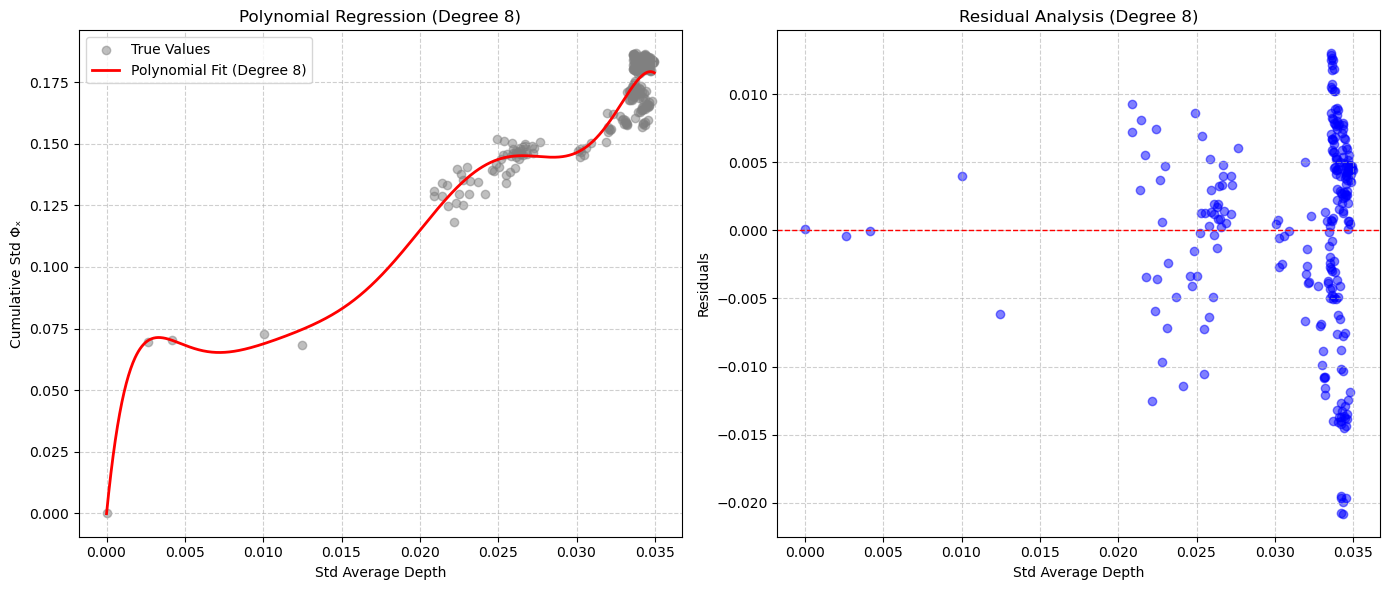

In [6]:
# --- Create polynomial features (degree = 8) ---
poly = PolynomialFeatures(degree=8)
X_poly = poly.fit_transform(X)

# --- Fit the polynomial regression model ---
model = LinearRegression()
model.fit(X_poly, y)

# --- Make predictions ---
y_pred = model.predict(X_poly)

# --- Calculate R² and MSE ---
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Polynomial Regression (Degree 8)")
print(f"R² Score: {r_squared:.4f}")
print(f"MSE: {mse:.6e}")

# --- Residuals ---
residuals = y - y_pred

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Fitted curve
axes[0].scatter(X, y, color='gray', alpha=0.5, label='True Values')

# Create smooth X values for plotting
X_smooth = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)

# Transform and predict on smooth X values
X_smooth_poly = poly.transform(X_smooth)
y_smooth_pred = model.predict(X_smooth_poly)

# Plot smooth curve
axes[0].plot(
    X_smooth,
    y_smooth_pred,
    color='red',
    linewidth=2,
    label='Polynomial Fit (Degree 8)'
)

axes[0].set_title('Polynomial Regression (Degree 8)')
axes[0].set_xlabel('Std Average Depth')
axes[0].set_ylabel('Cumulative Std Φₓ')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right: Residuals
axes[1].scatter(X, residuals, color='blue', alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Residual Analysis (Degree 8)')
axes[1].set_xlabel('Std Average Depth')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Results:

We can see that the model achieves a high R² score (0.90) and that the residuals are distributed close to zero, indicating a good fit. However, to evaluate whether the model generalizes well, we will now perform cross-validation to determine which polynomial degree yields the best predictive performance:

Cross-Validation Results (10-Fold): Std Average Depth → Cumulative Std Φx
 Degree    Mean_R²  Mean_MSE
      1   0.804789  0.000078
      2   0.798841  0.000084
      3   0.802777  0.000084
      4   0.779426  0.000124
      5   0.806999  0.000104
      6   0.727066  0.000241
      7   0.574663  0.000489
      8 -23.108932  0.038722
      9 -22.832644  0.038276
     10 -22.826539  0.038266

Best degree by R²:  5
Best degree by MSE: 1


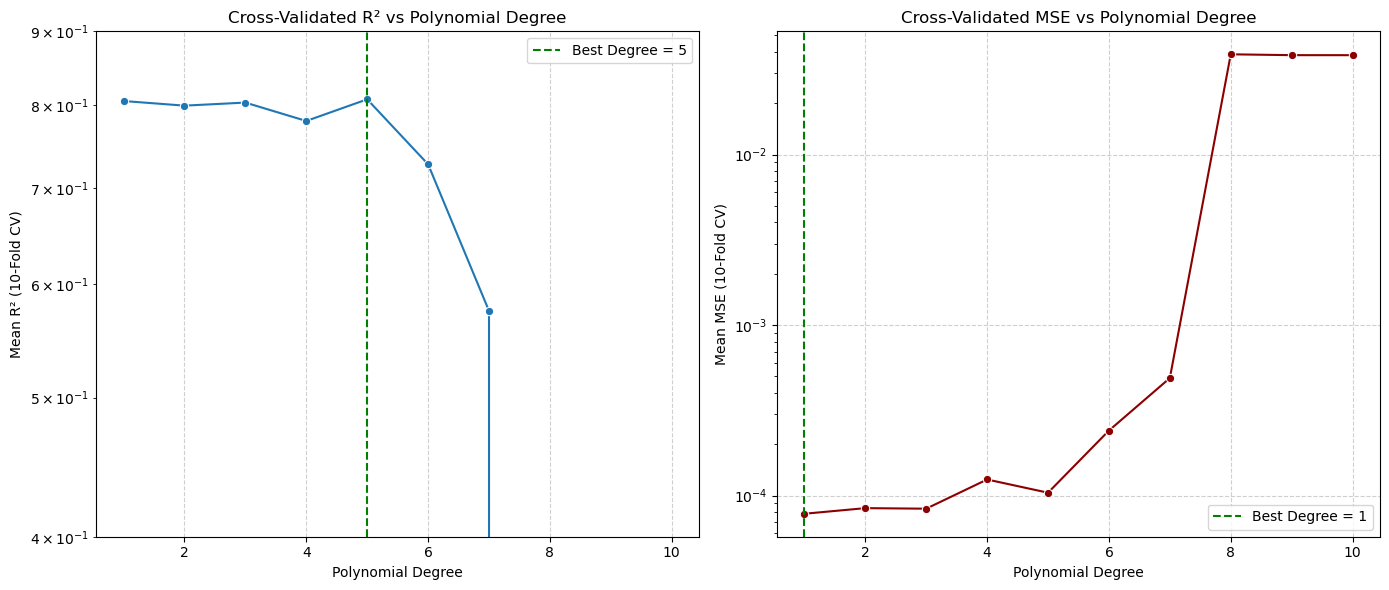

In [7]:
# --- Cross-validation setup (10-fold) ---
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Storage for results ---
results = []

# --- Loop over polynomial degrees 1–10 ---
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    
    # Cross-validated R² (higher = better)
    r2_scores = cross_val_score(model, X_poly, y, cv=kfold, scoring='r2')
    mean_r2 = np.mean(r2_scores)
    
    # Cross-validated MSE (lower = better)
    mse_scores = cross_val_score(model, X_poly, y, cv=kfold,
                                 scoring=make_scorer(mean_squared_error))
    mean_mse = np.mean(mse_scores)
    
    results.append((degree, mean_r2, mean_mse))

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results, columns=['Degree', 'Mean_R²', 'Mean_MSE'])

# --- Identify best degrees ---
best_degree_r2  = results_df.loc[results_df['Mean_R²'].idxmax(), 'Degree']
best_degree_mse = results_df.loc[results_df['Mean_MSE'].idxmin(), 'Degree']

print("Cross-Validation Results (10-Fold): Std Average Depth → Cumulative Std Φx")
print(results_df.to_string(index=False))
print(f"\nBest degree by R²:  {best_degree_r2}")
print(f"Best degree by MSE: {best_degree_mse}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² vs Degree
sns.lineplot(data=results_df, x='Degree', y='Mean_R²', marker='o', ax=axes[0])
axes[0].axvline(best_degree_r2, color='green', linestyle='--', label=f'Best Degree = {best_degree_r2}')
axes[0].set_title('Cross-Validated R² vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean R² (10-Fold CV)')
axes[0].set_yscale('log')  # clearer differences
axes[0].set_ylim(0.4, 0.9)  # clearer differences
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# MSE vs Degree
sns.lineplot(data=results_df, x='Degree', y='Mean_MSE', marker='o', ax=axes[1], color='darkred')
axes[1].axvline(best_degree_mse, color='green', linestyle='--', label=f'Best Degree = {best_degree_mse}')
axes[1].set_title('Cross-Validated MSE vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Mean MSE (10-Fold CV)')
axes[1].set_yscale('log')  # clearer differences
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

### Results:

The analysis indicates that the best-performing models are obtained with polynomial degrees 1 and 5, depending on whether the R² or MSE metric is considered. Since the cross-validation results show only marginal improvements in R² for degree 5 compared to degree 1, the model with degree 1 was selected. This choice minimizes model complexity and enhances interpretability while achieving a comparable R² score and a lower mean squared error.

## Final Model with best degree

Now, we take a look at the final model, which uses a polynomial regression of degree 1 (i.e., a linear regression):

Final Polynomial Regression (Degree 1)
R²:  0.8637
MSE: 7.531703e-05


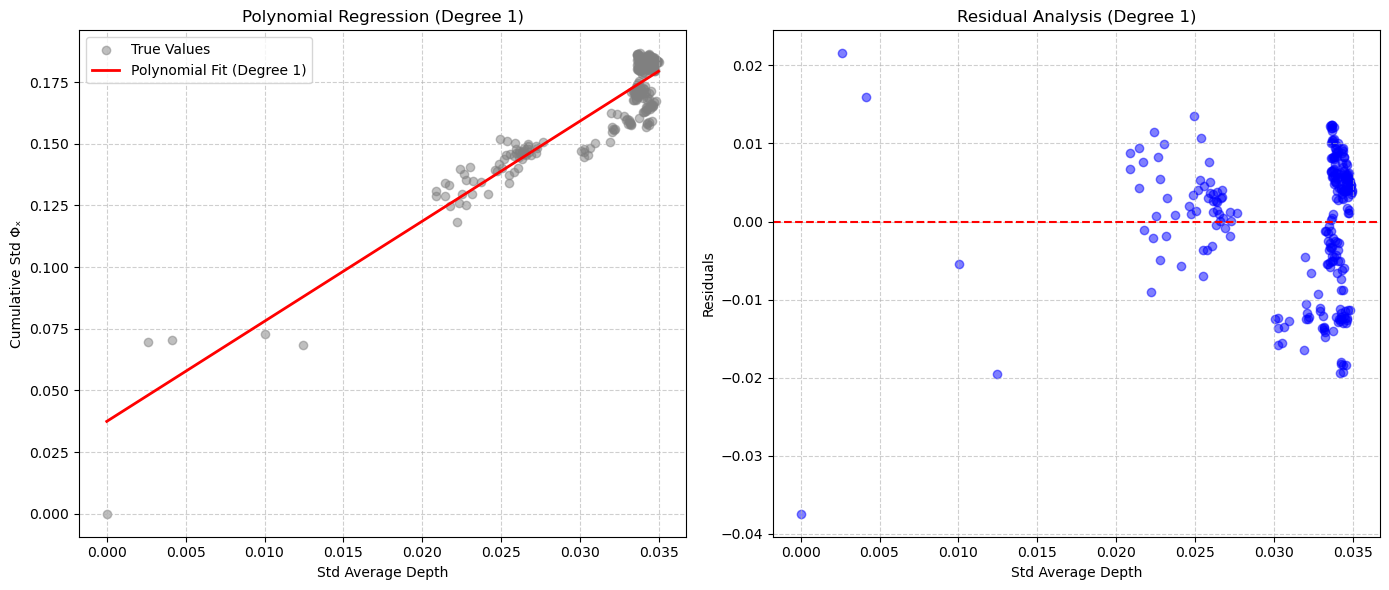

In [8]:
# --- Final Model with best degree ---
best_degree = 1

poly = PolynomialFeatures(degree=best_degree)
X_poly = poly.fit_transform(data_cleaned[['std_average_depth']].values)
y = data_cleaned['cumulative_std_angle_x']

model = LinearRegression()
model.fit(X_poly, y)

# Predictions
y_pred = model.predict(X_poly)

# Metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Final Polynomial Regression (Degree {best_degree})")
print(f"R²:  {r2:.4f}")
print(f"MSE: {mse:.6e}")

# Residuals
residuals = y - y_pred

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Fitted curve
axes[0].scatter(data_cleaned['std_average_depth'], y, color='gray', alpha=0.5, label='True Values')

# Smooth line
X_smooth = np.linspace(data_cleaned['std_average_depth'].min(),
                       data_cleaned['std_average_depth'].max(),
                       1000).reshape(-1, 1)
X_smooth_poly = poly.transform(X_smooth)
y_smooth_pred = model.predict(X_smooth_poly)

axes[0].plot(X_smooth, y_smooth_pred, color='red', linewidth=2,
             label=f'Polynomial Fit (Degree {best_degree})')
axes[0].set_title(f'Polynomial Regression (Degree {best_degree})')
axes[0].set_xlabel('Std Average Depth')
axes[0].set_ylabel('Cumulative Std Φₓ')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right: Residuals
axes[1].scatter(data_cleaned['std_average_depth'], residuals, color='blue', alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title(f'Residual Analysis (Degree {best_degree})')
axes[1].set_xlabel('Std Average Depth')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Results:

We obtain a slightly lower R² value, but the model generalizes better. The residuals also remain centered around zero, indicating that the model provides a good fit.

## Analysis of the relationship of `normalized_time` and `cumulative_std_angle_x`

We will now perform the same analysis for the relationship between `normalized_time` and `cumulative_std_angle_x`. We perform the analysis to find the best degree for this model by splitting the data into a training and test sample and looping over polynomial degrees. We then do a cross validation inside the loop:

Cross-Validation Results (10-Fold):
 Degree  Mean_R²  Mean_MSE
      1 0.683226  0.000201
      2 0.829781  0.000125
      3 0.830455  0.000120
      4 0.823687  0.000116
      5 0.806896  0.000143
      6 0.781046  0.000163
      7 0.742230  0.000183
      8 0.693808  0.000204
      9 0.640638  0.000226
     10 0.586967  0.000247

Best degree by R²:  3
Best degree by MSE: 4


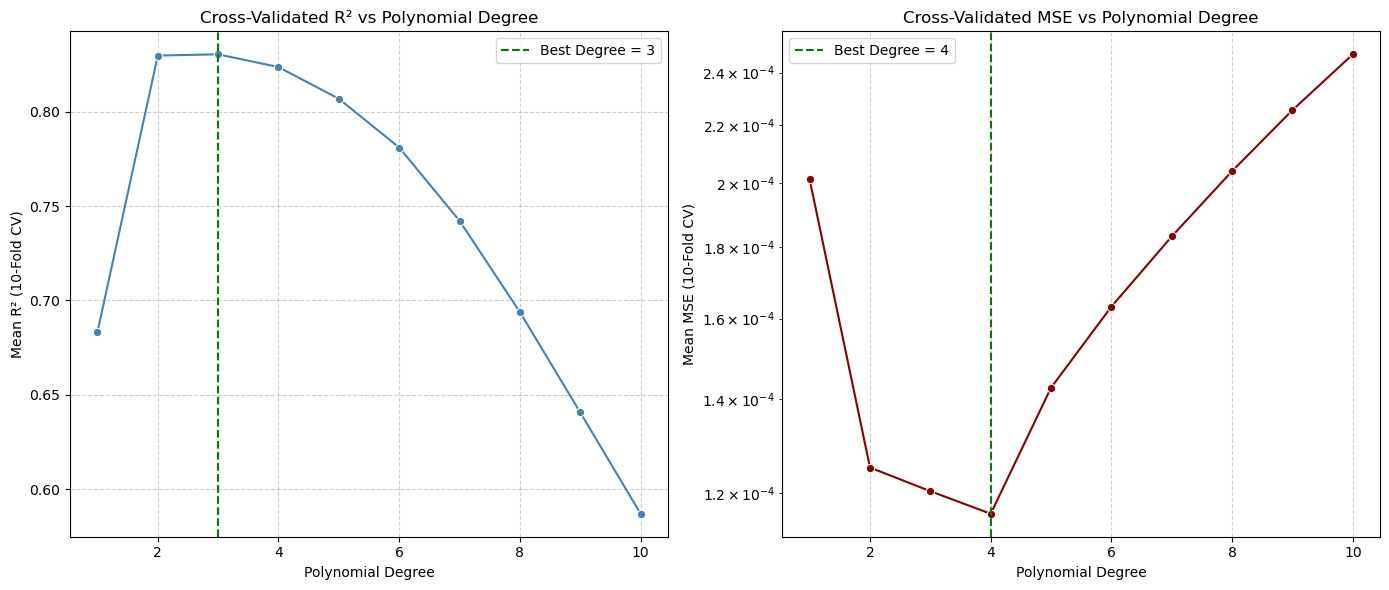

In [11]:
#  --- Prepare data (features for this relationship) ---
X2 = data_cleaned[['normalized_time']].values            # feature
y2 = data_cleaned['cumulative_std_angle_x'].values       # target

# Train-test split (80/20)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# --- Cross-validation setup (e.g. 10-fold) ---
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Storage for results ---
results = []

# --- Loop over polynomial degrees 1–10 ---
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X2)
    model = LinearRegression()
    
    # Cross-validated R² (higher = better)
    r2_scores = cross_val_score(model, X_poly, y2, cv=kfold, scoring='r2')
    mean_r2 = np.mean(r2_scores)
    
    # Cross-validated MSE (lower = better)
    mse_scores = cross_val_score(model, X_poly, y2, cv=kfold,
                                 scoring=make_scorer(mean_squared_error))
    mean_mse = np.mean(mse_scores)
    
    results.append((degree, mean_r2, mean_mse))

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results, columns=['Degree', 'Mean_R²', 'Mean_MSE'])

# --- Identify best degrees ---
best_degree_r2  = results_df.loc[results_df['Mean_R²'].idxmax(), 'Degree']
best_degree_mse = results_df.loc[results_df['Mean_MSE'].idxmin(), 'Degree']

print("Cross-Validation Results (10-Fold):")
print(results_df.to_string(index=False))
print(f"\nBest degree by R²:  {best_degree_r2}")
print(f"Best degree by MSE: {best_degree_mse}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² vs Degree
sns.lineplot(data=results_df, x='Degree', y='Mean_R²', marker='o', ax=axes[0], color='steelblue')
axes[0].axvline(best_degree_r2, color='green', linestyle='--', label=f'Best Degree = {best_degree_r2}')
axes[0].set_title('Cross-Validated R² vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean R² (10-Fold CV)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# MSE vs Degree
sns.lineplot(data=results_df, x='Degree', y='Mean_MSE', marker='o', ax=axes[1], color='darkred')
axes[1].axvline(best_degree_mse, color='green', linestyle='--', label=f'Best Degree = {best_degree_mse}')
axes[1].set_title('Cross-Validated MSE vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Mean MSE (10-Fold CV)')
axes[1].set_yscale('log')  # clearer differences
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

### Results:

The analysis indicates that the best-performing models are obtained with polynomial degrees 3 and 4, depending on whether the R² or MSE metric is considered. Since the cross-validation results show only marginal improvements in R² for degree 3 compared to degree 4, the model with degree 3 was selected. This choice minimizes model complexity and enhances interpretability while achieving a comparable R² score and a low mean squared error.

## Final Model with best degree

Now, we take a look at the final model, which uses a polynomial regression of degree 3:

Final Polynomial Regression (Degree 3)
R²:  0.8077
MSE: 1.062756e-04


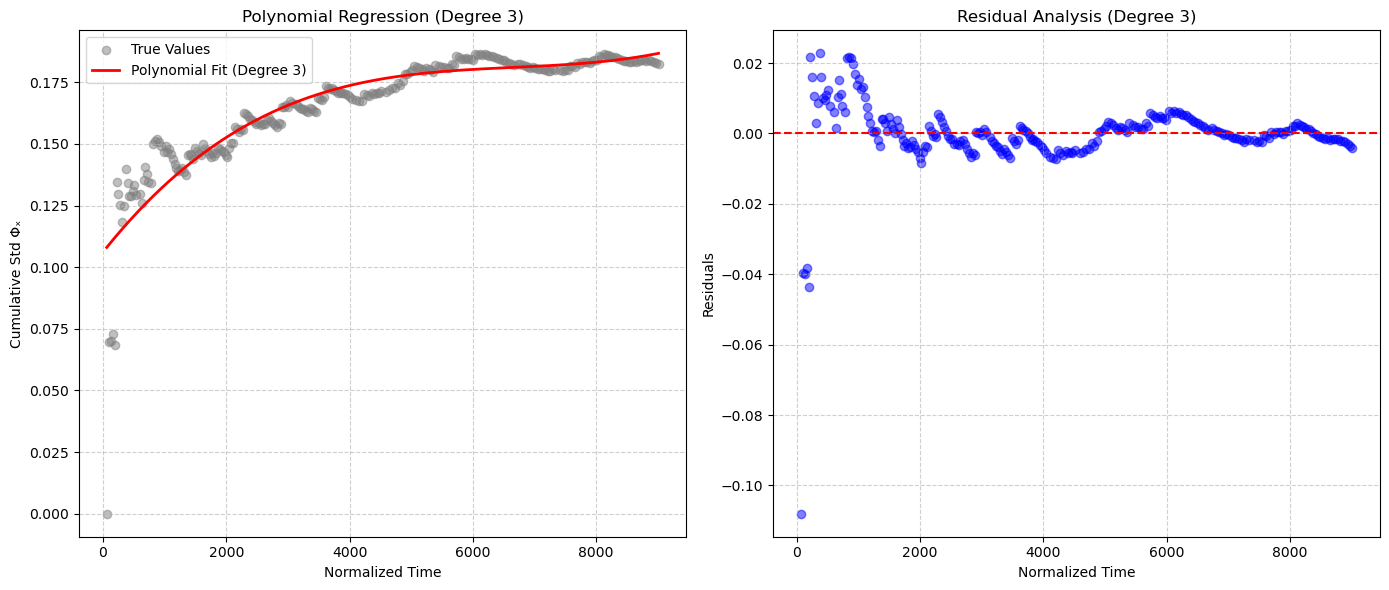

In [12]:
# --- Final Model with best degree ---
best_degree = 3  # or 4 based on MSE

poly = PolynomialFeatures(degree=best_degree)
X_poly = poly.fit_transform(data_cleaned[['normalized_time']].values)
y = data_cleaned['cumulative_std_angle_x']

model = LinearRegression()
model.fit(X_poly, y)

# Predictions
y_pred = model.predict(X_poly)

# Metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Final Polynomial Regression (Degree {best_degree})")
print(f"R²:  {r2:.4f}")
print(f"MSE: {mse:.6e}")

# Residuals
residuals = y - y_pred

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Fitted curve
axes[0].scatter(data_cleaned['normalized_time'], y, color='gray', alpha=0.5, label='True Values')

# Smooth line
X_smooth = np.linspace(data_cleaned['normalized_time'].min(), data_cleaned['normalized_time'].max(), 1000).reshape(-1, 1)
X_smooth_poly = poly.transform(X_smooth)
y_smooth_pred = model.predict(X_smooth_poly)

axes[0].plot(X_smooth, y_smooth_pred, color='red', linewidth=2, label=f'Polynomial Fit (Degree {best_degree})')
axes[0].set_title(f'Polynomial Regression (Degree {best_degree})')
axes[0].set_xlabel('Normalized Time')
axes[0].set_ylabel('Cumulative Std Φₓ')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right: Residuals
axes[1].scatter(data_cleaned['normalized_time'], residuals, color='blue', alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title(f'Residual Analysis (Degree {best_degree})')
axes[1].set_xlabel('Normalized Time')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Results:

We obtain a higher R² value, and the model generalizes better. The residuals also remain centered around zero, indicating that the model provides a good fit.

## Analysis of the relationship of `normalized_time` and `std_average_depth`

We will now perform the same analysis for the relationship between `normalized_time` and `std_average_depth`. We perform the analysis to find the best degree for this model by splitting the data into a training and test sample and looping over polynomial degrees. We then do a cross validation inside the loop:

Cross-Validation Results (10-Fold):
 Degree   Mean_R²  Mean_MSE
      1  0.172466  0.000016
      2  0.647999  0.000008
      3  0.823266  0.000005
      4  0.830967  0.000005
      5  0.798655  0.000006
      6  0.655840  0.000009
      7  0.435993  0.000012
      8  0.226803  0.000016
      9  0.069082  0.000018
     10 -0.040142  0.000020

Best degree by R²:  4
Best degree by MSE: 4


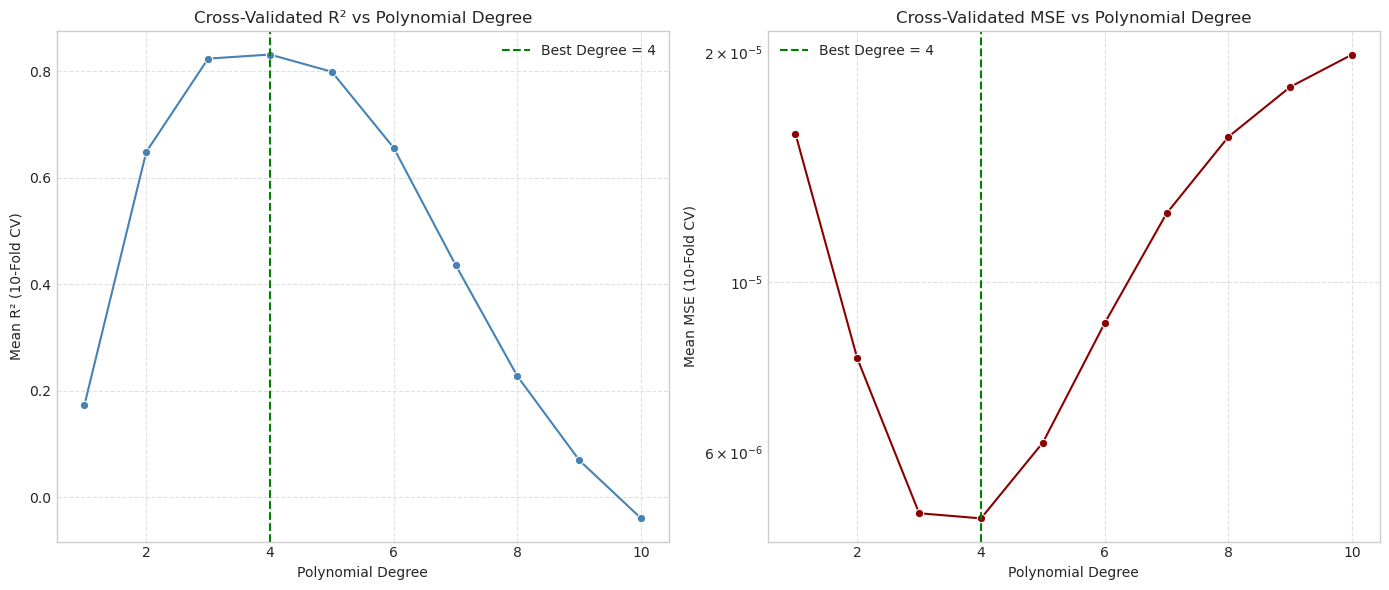

In [20]:
# --- Prepare data (features for this relationship) ---
X3 = data_cleaned[['normalized_time']].values        # feature
y3 = data_cleaned['std_average_depth'].values        # target

# Train-test split (80/20)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# --- Cross-validation setup (e.g. 10-fold) ---
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Storage for results ---
results = []

# --- Loop over polynomial degrees 1–10 ---
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X3)
    model = LinearRegression()
    
    # Cross-validated R² (higher = better)
    r2_scores = cross_val_score(model, X_poly, y3, cv=kfold, scoring='r2')
    mean_r2 = np.mean(r2_scores)
    
    # Cross-validated MSE (lower = better)
    mse_scores = cross_val_score(model, X_poly, y3, cv=kfold,
                                 scoring=make_scorer(mean_squared_error))
    mean_mse = np.mean(mse_scores)
    
    results.append((degree, mean_r2, mean_mse))

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results, columns=['Degree', 'Mean_R²', 'Mean_MSE'])

# --- Identify best degrees ---
best_degree_r2  = results_df.loc[results_df['Mean_R²'].idxmax(), 'Degree']
best_degree_mse = results_df.loc[results_df['Mean_MSE'].idxmin(), 'Degree']

print("Cross-Validation Results (10-Fold):")
print(results_df.to_string(index=False))
print(f"\nBest degree by R²:  {best_degree_r2}")
print(f"Best degree by MSE: {best_degree_mse}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² vs Degree
sns.lineplot(data=results_df, x='Degree', y='Mean_R²', marker='o', ax=axes[0], color='steelblue')
axes[0].axvline(best_degree_r2, color='green', linestyle='--', label=f'Best Degree = {best_degree_r2}')
axes[0].set_title('Cross-Validated R² vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean R² (10-Fold CV)')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# MSE vs Degree
sns.lineplot(data=results_df, x='Degree', y='Mean_MSE', marker='o', ax=axes[1], color='darkred')
axes[1].axvline(best_degree_mse, color='green', linestyle='--', label=f'Best Degree = {best_degree_mse}')
axes[1].set_title('Cross-Validated MSE vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Mean MSE (10-Fold CV)')
axes[1].set_yscale('log')  # clearer differences
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

### Results:

The analysis indicates that the best-performing models are obtained with polynomial degree 4 with a much higher value of R² and a lower value of MSE.

## Final Model with best degree

Now, we take a look at the final model, which uses a polynomial regression of degree 4:

Final Polynomial Regression (Degree 4)
R²:  0.8633
MSE: 3.955430e-06


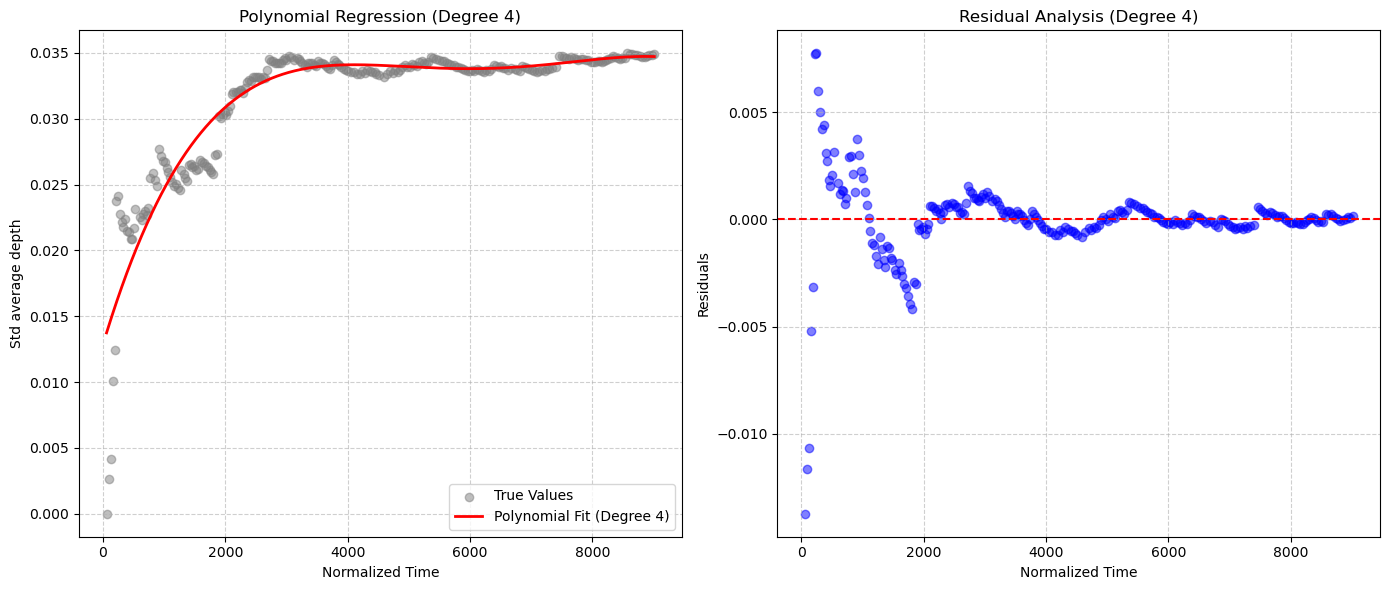

In [16]:
# --- Final Model with best degree ---
best_degree = 4

poly = PolynomialFeatures(degree=best_degree)
X_poly = poly.fit_transform(data_cleaned[['normalized_time']].values)
y = data_cleaned['std_average_depth']

model = LinearRegression()
model.fit(X_poly, y)

# Predictions
y_pred = model.predict(X_poly)

# Metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Final Polynomial Regression (Degree {best_degree})")
print(f"R²:  {r2:.4f}")
print(f"MSE: {mse:.6e}")

# Residuals
residuals = y - y_pred

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Fitted curve
axes[0].scatter(data_cleaned['normalized_time'], y, color='gray', alpha=0.5, label='True Values')

# Smooth line
X_smooth = np.linspace(data_cleaned['normalized_time'].min(), data_cleaned['normalized_time'].max(), 1000).reshape(-1, 1)
X_smooth_poly = poly.transform(X_smooth)
y_smooth_pred = model.predict(X_smooth_poly)

axes[0].plot(X_smooth, y_smooth_pred, color='red', linewidth=2, label=f'Polynomial Fit (Degree {best_degree})')
axes[0].set_title(f'Polynomial Regression (Degree {best_degree})')
axes[0].set_xlabel('Normalized Time')
axes[0].set_ylabel('Std average depth')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right: Residuals
axes[1].scatter(data_cleaned['normalized_time'], residuals, color='blue', alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title(f'Residual Analysis (Degree {best_degree})')
axes[1].set_xlabel('Normalized Time')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Results:

As expected, we obtain a higher R² value, and the model generalizes well. The residuals also remain centered around zero, indicating that the model provides a good fit.

## Final Results and Plots for the Univariate Analysis of the Features

Before moving on to the multivariate analysis, we combine the final plots of the three different models into a single figure for comparison.

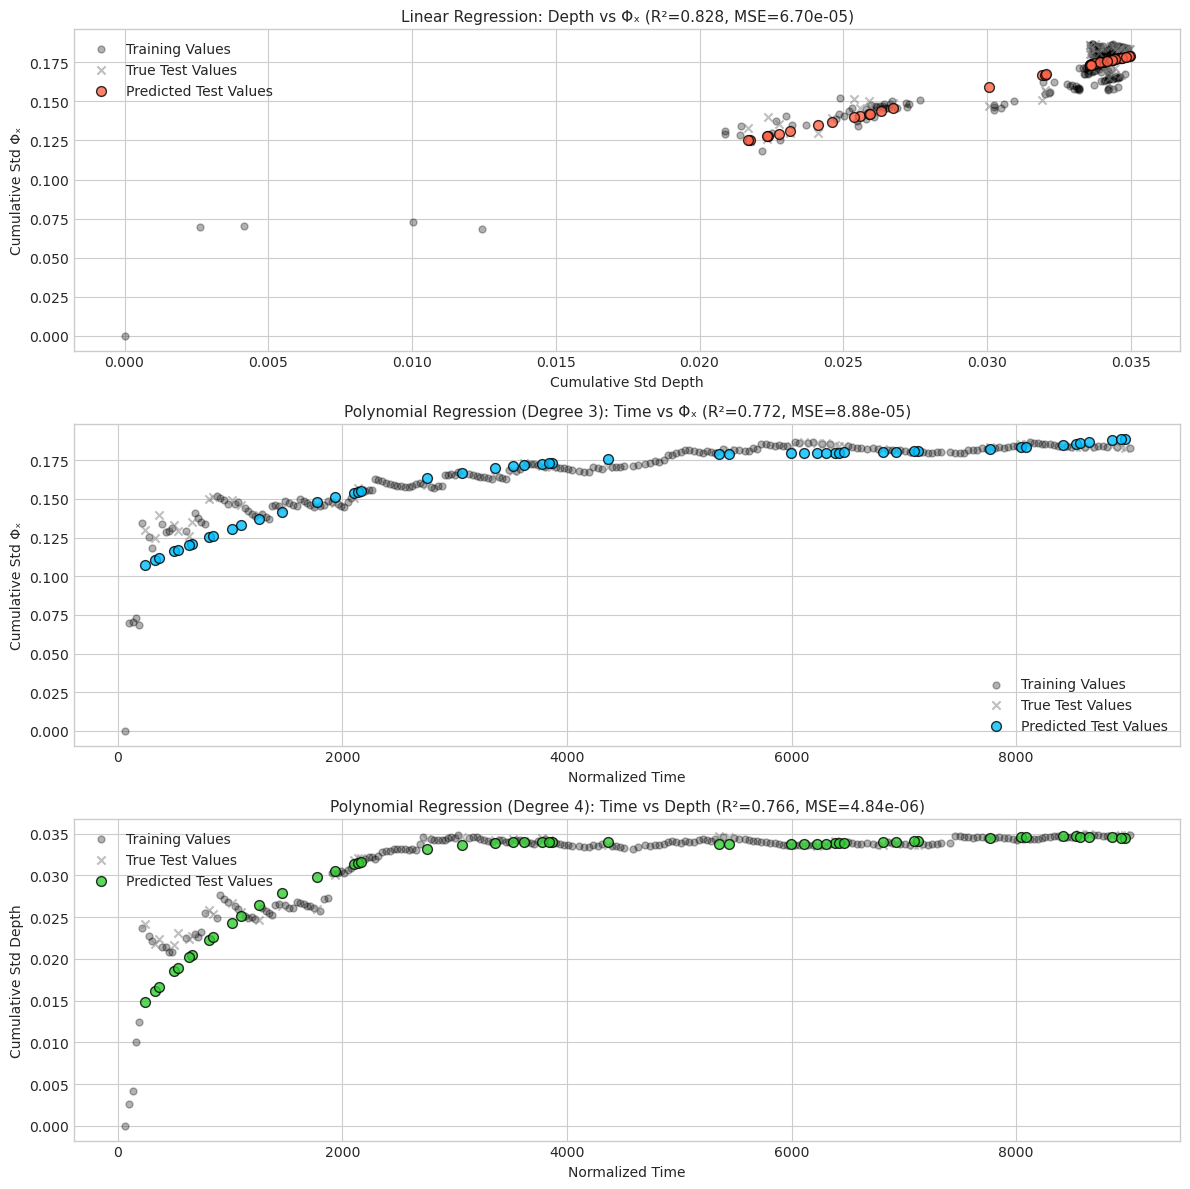

In [17]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

# ==========================================================
# 1 Linear Regression: Cumulative Std Depth vs. Cumulative Std Φₓ
# ==========================================================
X1 = data_cleaned[['std_average_depth']].values
y1 = data_cleaned['cumulative_std_angle_x'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)

r2_1 = r2_score(y1_test, y1_pred)
mse_1 = mean_squared_error(y1_test, y1_pred)

# Sort for smooth line
sort_idx = np.argsort(X1_test.flatten())
axes[0].scatter(X1_train, y1_train, color='black', alpha=0.3, s=25, marker='o', label='Training Values')
axes[0].scatter(X1_test, y1_test, color='gray', alpha=0.5, s=35, marker='x', label='True Test Values')
axes[0].scatter(X1_test, y1_pred, color='tomato', alpha=0.8, s=50, marker='o', edgecolor='black', label='Predicted Test Values')

axes[0].set_title(f'Linear Regression: Depth vs Φₓ (R²={r2_1:.3f}, MSE={mse_1:.2e})', fontsize=11)
axes[0].set_xlabel('Cumulative Std Depth')
axes[0].set_ylabel('Cumulative Std Φₓ')
axes[0].legend()


# ==========================================================
# 2 Non-linear Regression (Degree 3): Normalized Time vs. Cumulative Std Φₓ
# ==========================================================
X2 = data_cleaned[['normalized_time']].values
y2 = data_cleaned['cumulative_std_angle_x'].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

poly2 = PolynomialFeatures(degree=3)
X2_poly_train = poly2.fit_transform(X2_train)
X2_poly_test = poly2.transform(X2_test)

model2 = LinearRegression()
model2.fit(X2_poly_train, y2_train)
y2_pred = model2.predict(X2_poly_test)

r2_2 = r2_score(y2_test, y2_pred)
mse_2 = mean_squared_error(y2_test, y2_pred)

# Smooth curve
X2_smooth = np.linspace(X2.min(), X2.max(), 1000).reshape(-1, 1)
y2_smooth = model2.predict(poly2.transform(X2_smooth))

axes[1].scatter(X2_train, y2_train, color='black', alpha=0.3, s=25, marker='o', label='Training Values')
axes[1].scatter(X2_test, y2_test, color='gray', alpha=0.5, s=35, marker='x', label='True Test Values')
axes[1].scatter(X2_test, y2_pred, color='deepskyblue', alpha=0.8, s=50, marker='o', edgecolor='black', label='Predicted Test Values')

axes[1].set_title(f'Polynomial Regression (Degree 3): Time vs Φₓ (R²={r2_2:.3f}, MSE={mse_2:.2e})', fontsize=11)
axes[1].set_xlabel('Normalized Time')
axes[1].set_ylabel('Cumulative Std Φₓ')
axes[1].legend()


# ==========================================================
# 3 Non-linear Regression (Degree 4): Normalized Time vs. Cumulative Std Depth
# ==========================================================
y3 = data_cleaned['std_average_depth'].values
X3 = data_cleaned[['normalized_time']].values

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

poly3 = PolynomialFeatures(degree=4)
X3_poly_train = poly3.fit_transform(X3_train)
X3_poly_test = poly3.transform(X3_test)

model3 = LinearRegression()
model3.fit(X3_poly_train, y3_train)
y3_pred = model3.predict(X3_poly_test)

r2_3 = r2_score(y3_test, y3_pred)
mse_3 = mean_squared_error(y3_test, y3_pred)

# Smooth curve
X3_smooth = np.linspace(X3.min(), X3.max(), 1000).reshape(-1, 1)
y3_smooth = model3.predict(poly3.transform(X3_smooth))

axes[2].scatter(X3_train, y3_train, color='black', alpha=0.3, s=25, marker='o', label='Training Values')
axes[2].scatter(X3_test, y3_test, color='gray', alpha=0.5, s=35, marker='x', label='True Test Values')
axes[2].scatter(X3_test, y3_pred, color='limegreen', alpha=0.8, s=50, marker='o', edgecolor='black', label='Predicted Test Values')

axes[2].set_title(f'Polynomial Regression (Degree 4): Time vs Depth (R²={r2_3:.3f}, MSE={mse_3:.2e})', fontsize=11)
axes[2].set_xlabel('Normalized Time')
axes[2].set_ylabel('Cumulative Std Depth')
axes[2].legend()

plt.show()

## Discussion

From the results:
- The polynomial models with degrees 1, 3, and 4 achieved the best balance between model complexity and performance.
- The R² scores from the test data (0.828, 0.772, and 0.766), (not to be confused with the scores from the entire dataset: 0.8637, 0.8077, 0.8633), indicate a strong correlation between predicted and actual values.
- For higher polynomial degrees, overfitting effects become apparent: the predictions fit the training data too closely, leading to reduced test performance.
- The residual plots show that the errors are symmetrically distributed (especially after the first few measurements), suggesting no major bias in the models.

Overall, the analysis confirms that a moderately complex polynomial regression effectively captures the nonlinear physical relationships present in the dataset.

## Multivariate Polynomial Regression

In the following section, we extend the previous univariate analysis to a multivariate polynomial regression, using both `normalized_time` and `std_average_depth` as input features to predict `cumulative_std_angle_x`.
This approach allows us to examine how the combined influence of time normalization and average depth variation affects the cumulative angular deviation.
By incorporating multiple correlated predictors, the model aims to capture more complex, nonlinear dependencies that were not observable in the single-variable regressions.

Cross-Validation Results (10-Fold):
 Degree  Mean_R²  Mean_MSE
      1 0.901811  0.000054
      2 0.945505  0.000029
      3 0.944050  0.000029
      4 0.827575  0.000109
      5 0.799668  0.000143
      6 0.776327  0.000163

Best degree by R²:  2
Best degree by MSE: 3


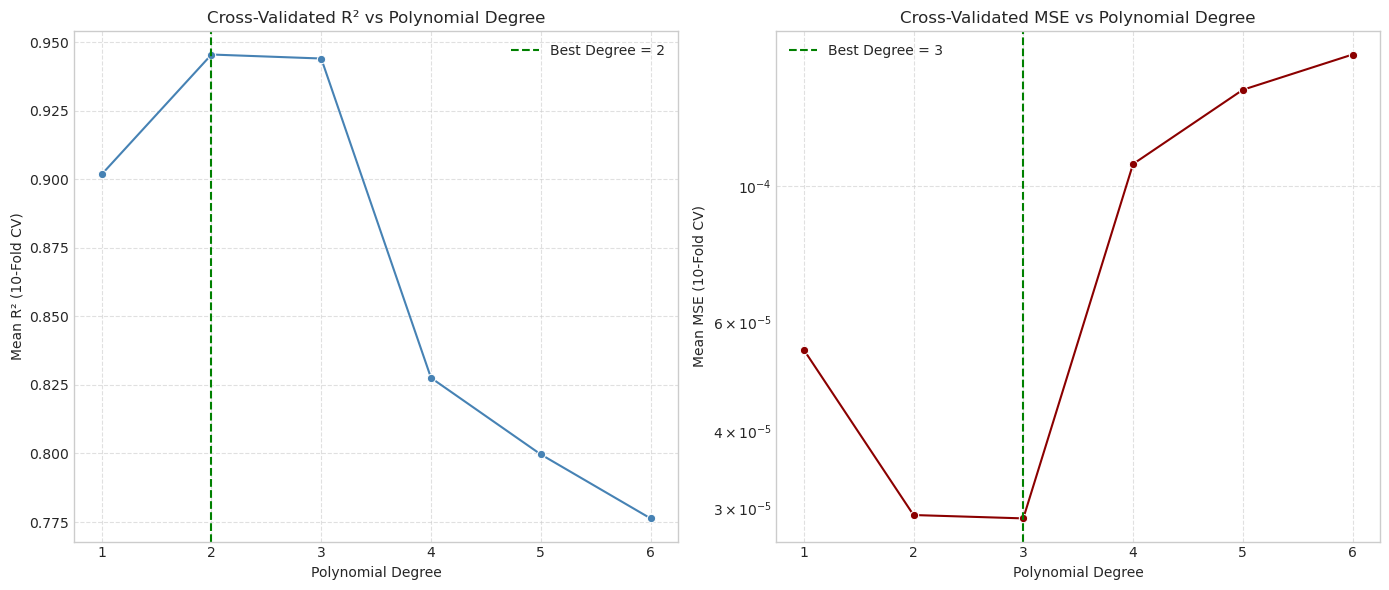

In [18]:
# --- Data ---
X_multi = data_cleaned[['normalized_time', 'std_average_depth']].values
y_multi = data_cleaned['cumulative_std_angle_x'].values

# --- Cross-validation setup ---
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Storage ---
results = []

for degree in range(1, 7):  # test degrees 1–6
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_multi)
    model = LinearRegression()

    # R²
    r2_scores = cross_val_score(model, X_poly, y_multi, cv=kfold, scoring='r2')
    mean_r2 = np.mean(r2_scores)

    # MSE
    mse_scores = cross_val_score(model, X_poly, y_multi, cv=kfold,
                                 scoring=make_scorer(mean_squared_error))
    mean_mse = np.mean(mse_scores)

    results.append((degree, mean_r2, mean_mse))

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results, columns=['Degree', 'Mean_R²', 'Mean_MSE'])

# --- Best degree ---
best_degree_r2 = results_df.loc[results_df['Mean_R²'].idxmax(), 'Degree']
best_degree_mse = results_df.loc[results_df['Mean_MSE'].idxmin(), 'Degree']

print("Cross-Validation Results (10-Fold):")
print(results_df.to_string(index=False))
print(f"\nBest degree by R²:  {best_degree_r2}")
print(f"Best degree by MSE: {best_degree_mse}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(data=results_df, x='Degree', y='Mean_R²', marker='o', ax=axes[0], color='steelblue')
axes[0].axvline(best_degree_r2, color='green', linestyle='--', label=f'Best Degree = {best_degree_r2}')
axes[0].set_title('Cross-Validated R² vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean R² (10-Fold CV)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.lineplot(data=results_df, x='Degree', y='Mean_MSE', marker='o', ax=axes[1], color='darkred')
axes[1].axvline(best_degree_mse, color='green', linestyle='--', label=f'Best Degree = {best_degree_mse}')
axes[1].set_title('Cross-Validated MSE vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Mean MSE (10-Fold CV)')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Results:

The cross-validation results show that polynomial degrees 2 and 3 provide the best overall performance.
Degree 2 yields the highest mean R² (0.9455), while degree 3 achieves a nearly identical R² (0.9440) but with the same mean MSE. Since the improvement beyond degree 2 is negligible and higher degrees tend to increase model complexity and the risk of overfitting, degree 2 represents the optimal trade-off between accuracy and generalization.


Polynomial Regression Coefficients:
Intercept: 0.02269098
                          Feature   Coefficient
                                1  0.000000e+00
                  normalized_time  3.400000e-07
                std_average_depth  7.541225e+00
                normalized_time^2 -0.000000e+00
normalized_time std_average_depth  4.293800e-04
              std_average_depth^2 -1.311885e+02

Multivariate Polynomial Regression (Degree 2)
R² (Train): 0.9588
R² (Test):  0.9589
MSE (Train): 2.442518e-05
MSE (Test):  1.596837e-05

10-Fold Cross-Validation:
Mean R²:  0.9455 ± 0.0311
Mean MSE: 2.921109e-05 ± 2.5e-05


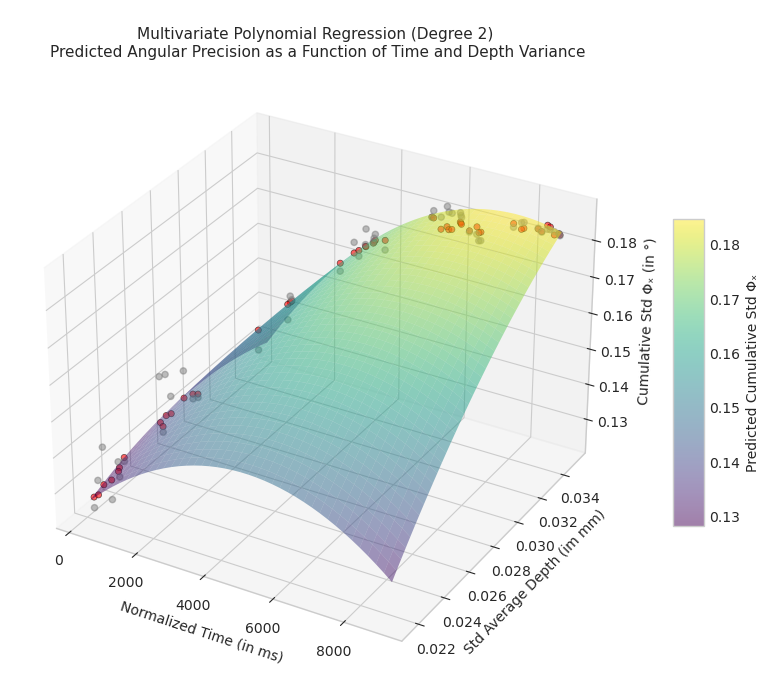

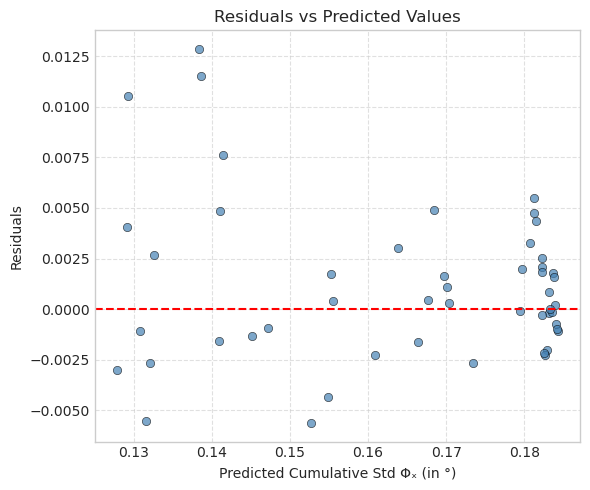


Summary of Multivariate Model:
     Metric    Value
 R² (Train) 0.958846
  R² (Test) 0.958931
MSE (Train) 0.000024
 MSE (Test) 0.000016
 CV Mean R² 0.945505
CV Mean MSE 0.000029


In [37]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ==========================================================
# Multivariate Polynomial Regression
# Inputs: normalized_time, std_average_depth
# Target: cumulative_std_angle_x
# ==========================================================

# --- Prepare Data ---
X_multi = data_cleaned[['normalized_time', 'std_average_depth']].values
y_multi = data_cleaned['cumulative_std_angle_x'].values

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# --- Polynomial Transformation (you can tune degree) ---
best_degree = 2
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# --- Fit Model ---
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Get polynomial feature names for readability
feature_names = poly.get_feature_names_out(['normalized_time', 'std_average_depth'])

# Combine coefficients and feature names into a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_.round(8)
})
print("\nPolynomial Regression Coefficients:")
print(f"Intercept: {model.intercept_:.8f}")
print(coef_df.to_string(index=False))

# --- Predictions ---
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# --- Metrics ---
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)

print(f"\nMultivariate Polynomial Regression (Degree {best_degree})")
print(f"R² (Train): {r2_train:.4f}")
print(f"R² (Test):  {r2_test:.4f}")
print(f"MSE (Train): {mse_train:.6e}")
print(f"MSE (Test):  {mse_test:.6e}")

# --- Cross-Validation ---
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_r2 = cross_val_score(model, poly.fit_transform(X_multi), y_multi, cv=kfold, scoring='r2')
cv_mse = -cross_val_score(model, poly.fit_transform(X_multi), y_multi, cv=kfold, scoring='neg_mean_squared_error')

print("\n10-Fold Cross-Validation:")
print(f"Mean R²:  {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"Mean MSE: {cv_mse.mean():.6e} ± {cv_mse.std():.1e}")

# ==========================================================
# 3D Visualization – Predicted Surface vs. True Data
# ==========================================================

# --- Create a meshgrid (smooth grid of time & depth) ---
time_range = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 40)
depth_range = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 40)
T_mesh, D_mesh = np.meshgrid(time_range, depth_range)

# Flatten the grid for prediction
X_grid = np.column_stack([T_mesh.ravel(), D_mesh.ravel()])
X_grid_poly = poly.transform(X_grid)

# Predict on the grid
Y_pred_grid = model.predict(X_grid_poly)
Y_pred_grid = Y_pred_grid.reshape(T_mesh.shape)

# --- Plot the 3D surface ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# True values
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='gray', alpha=0.5, label='True Values')

# Predicted values (points)
ax.scatter(X_test[:, 0], X_test[:, 1], y_test_pred, color='red', alpha=0.6, edgecolor='black', linewidths=0.5, label='Predicted Values')

# Regression surface
surface = ax.plot_surface(T_mesh, D_mesh, Y_pred_grid, cmap='viridis', alpha=0.5, rstride=1, cstride=1, linewidth=0, antialiased=True, label='Polynomial Fit Surface')

# Labels & legend
ax.set_title(f'\nMultivariate Polynomial Regression (Degree {best_degree}) \nPredicted Angular Precision as a Function of Time and Depth Variance', fontsize=11)
ax.set_xlabel('Normalized Time (in ms)')
ax.set_ylabel('Std Average Depth (im mm)')
ax.set_zlabel('Cumulative Std Φₓ (in °)')

cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Predicted Cumulative Std Φₓ')

plt.tight_layout()
plt.show()

# ==========================================================
# Residual Analysis
# ==========================================================

residuals = y_test - y_test_pred

plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test_pred, y=residuals, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Cumulative Std Φₓ (in °)')
plt.ylabel('Residuals')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ==========================================================
# Summary Table
# ==========================================================

results_df = pd.DataFrame({
    'Metric': ['R² (Train)', 'R² (Test)', 'MSE (Train)', 'MSE (Test)', 'CV Mean R²', 'CV Mean MSE'],
    'Value': [r2_train, r2_test, mse_train, mse_test, cv_r2.mean(), cv_mse.mean()]
})

print("\nSummary of Multivariate Model:")
print(results_df.to_string(index=False))

### Discussion – Combined Model

The multivariate polynomial regression (degree 2) demonstrates excellent performance and generalization capability.
The model achieves an R² score of approximately 0.96 on both the training and test sets, indicating that it explains around 96% of the variance in the target variable. The MSE values are very low and consistent between training (2.4 × 10⁻⁵) and test data (1.6 × 10⁻⁵), suggesting minimal overfitting and a high predictive accuracy.

The 10-fold cross-validation further supports this conclusion, with a mean R² of 0.9455 ± 0.03 and a mean MSE of around 2.9 × 10⁻⁵, showing that the model performs robustly across different data splits.

Overall, the degree-2 multivariate polynomial captures the underlying nonlinear relationships effectively while maintaining strong generalization performance. Both normalized time and average depth stability contribute meaningfully to explaining the cumulative angular deviation (Φₓ).

The prediction formula has the following shape:
$$
\hat{\sigma}_{\Phi_x} = \beta_0 + \beta_1 \cdot σ_{depth} + \beta_2 \cdot σ_{depth}^2 + \beta_3 \cdot t + \beta_4 \cdot t^2 + \beta_5 \cdot σ_{depth} \cdot t
$$

with $ t $ the normalized time and $ σ_{depth} $ the cumulative standard deviation of the angular metric. The polynomial regression coefficients $ \beta_0 $ to $ \beta_5$ are displayed in the cell above.

## Conclusion

The analysis demonstrates that polynomial regression is an effective approach for modeling the nonlinear physical relationships in the dataset.
Through systematic testing of polynomial degrees, both in univariate and multivariate settings, we identified models that balance accuracy and generalization while avoiding overfitting.

In the univariate analysis, moderate polynomial degrees (1–4) already provided strong results, revealing clear correlations between normalized time, average depth stability (cumulative deviation of depth), and cumulative angular deviation (Φₓ).
However, extending the model to a multivariate polynomial regression (degree 2) significantly improved predictive performance, achieving an R² of ≈ 0.96 and a mean cross-validated R² of ≈ 0.95.
This confirms that time progression and depth stability jointly determine the angular behavior observed in the system.

Residual analyses showed no systematic bias and indicated that the models generalize well.
Overall, the degree-2 multivariate polynomial regression provides a compact, interpretable, and robust model that accurately captures the underlying nonlinear dynamics of the measurement process.

## References and Repository

This notebook is part of Deliverable 1.

- **Deliverable 2 (Video Demo):** [https://www.youtube.com/watch?v=MZcvllxoXZ0]
- **Deliverable 3 (GitHub Repository):** [https://github.com/TimArniko/ML-projects]

All code, plots, and data used here are available in the public repository.
